In [1]:
import torch
import traceback
import torch_scatter
import yaml
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
import sys
import random
sys.path.append('/home/yang_liu/python_workspace/3DGS')

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import makedirs
from torch import nn
from scene import Scene, LargeScene
from scene.datasets import GSDataset
from gaussian_renderer import render, render_v2
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import GaussianModel
from arguments import ModelParams, PipelineParams, OptimizationParams, GroupParams
from utils.loss_utils import l1_loss, ssim
from utils.general_utils import build_rotation, build_symmetric
from pytorch3d.transforms import matrix_to_quaternion

from scene.cameras import Camera
from utils.general_utils import PILtoTorch

WARNED = False

In [2]:
def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

def contract_to_unisphere(
        x: torch.Tensor,
        aabb: torch.Tensor,
        ord: float = 2,
        eps: float = 1e-6,
        derivative: bool = False,
    ):
        aabb_min, aabb_max = torch.split(aabb, 3, dim=-1)
        x = (x - aabb_min) / (aabb_max - aabb_min)
        x = x * 2 - 1  # aabb is at [-1, 1]
        mag = torch.linalg.norm(x, ord=ord, dim=-1, keepdim=True)
        mask = mag.squeeze(-1) > 1

        if derivative:
            dev = (2 * mag - 1) / mag**2 + 2 * x**2 * (
                1 / mag**3 - (2 * mag - 1) / mag**4
            )
            dev[~mask] = 1.0
            dev = torch.clamp(dev, min=eps)
            return dev
        else:
            x[mask] = (2 - 1 / mag[mask]) * (x[mask] / mag[mask])
            x = x / 4 + 0.5  # [-inf, inf] is at [0, 1]
            return x

def loadCam(args, id, cam_info, resolution_scale, with_image=True):
    orig_w, orig_h = cam_info.image.size

    if args.resolution in [1, 2, 4, 8]:
        resolution = round(orig_w/(resolution_scale * args.resolution)), round(orig_h/(resolution_scale * args.resolution))
    else:  # should be a type that converts to float
        if args.resolution == -1:
            if orig_w > 1600:
                global WARNED
                if not WARNED:
                    print("[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.\n "
                        "If this is not desired, please explicitly specify '--resolution/-r' as 1")
                    WARNED = True
                global_down = orig_w / 1600
            else:
                global_down = 1
        else:
            global_down = orig_w / args.resolution

        scale = float(global_down) * float(resolution_scale)
        resolution = (int(orig_w / scale), int(orig_h / scale))

    loaded_mask = None
    resized_image_rgb = torch.zeros((3, resolution[1], resolution[0]), dtype=torch.float32)
    gt_image = torch.zeros((3, resolution[1], resolution[0]), dtype=torch.float32)
    if with_image:
        resized_image_rgb = PILtoTorch(cam_info.image, resolution)
        gt_image = resized_image_rgb[:3, ...]

        if resized_image_rgb.shape[1] == 4:
            loaded_mask = resized_image_rgb[3:4, ...]

    return Camera(colmap_id=cam_info.uid, R=cam_info.R, T=cam_info.T, 
                  FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                  image=gt_image, gt_alpha_mask=loaded_mask,
                  image_name=cam_info.image_name, uid=id, data_device=args.data_device)

In [3]:
config = '../config/block_residence_all_lr_c20_loss_8_r4.yaml'
iteration = 30_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
config_name = os.path.splitext(os.path.basename(config))[0]
lp.source_path = os.path.join("../", lp.source_path)
lp.model_path = os.path.join("../output/", config_name)

with torch.no_grad():
    gaussians = GaussianModel(lp.sh_degree)
    scene = LargeScene(lp, gaussians, load_iteration=iteration, shuffle=False)
    # scene = LargeScene(lp, gaussians, shuffle=False)
    print(f'Loaded {lp.model_path}\n')

Loading trained model at iteration 30000
Reading camera 2561/2561
Loaded ../output/block_residence_all_lr_c20_loss_8_r4



In [4]:
xy_range = [-25, -200, -270, 175, 200, 60]
block_dim = [4, 1, 5]
num_threshold = 25000
cell_id = 0

Length of masked gaussians: 103709 for cell 0
[-0.01, 0.26], [-0.01, 1.01], [-0.01, 0.21000000000000002]
Mean of Gaussians in Blocks: 540635.4
Std of Gaussians in Blocks: 155173.1192605214


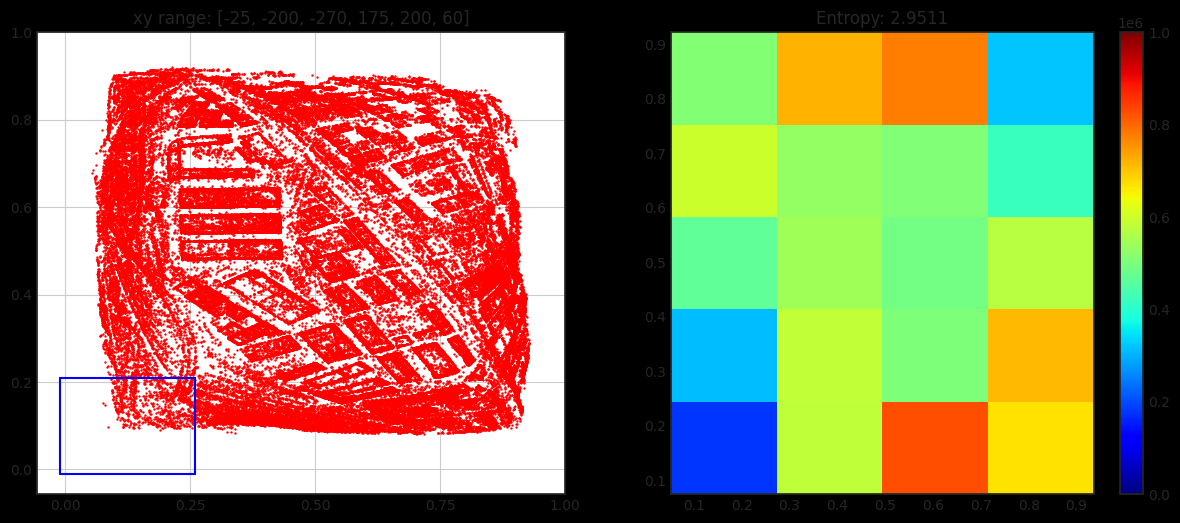

In [5]:
# show area of two blocks under BEV
# xy_range = [-5, 0, 5, 4]

with torch.no_grad():
    xyz_org = gaussians.get_xyz
    if len(xy_range) == 4:
        aabb = [xy_range[0], xy_range[1], xyz_org[:, -1].min(), 
                xy_range[2], xy_range[3], xyz_org[:, -1].max()]
    elif len(xy_range) == 6:
        aabb = xy_range
    else:
        assert False, "Unknown aabb format!"
    aabb = torch.tensor(aabb, dtype=torch.float32, device=xyz_org.device)
    xyz = contract_to_unisphere(xyz_org, aabb, ord=torch.inf)

cell_id_z = cell_id // (block_dim[0] * block_dim[1])
cell_id_y = (cell_id % (block_dim[0] * block_dim[1])) // block_dim[0]
cell_id_x = (cell_id % (block_dim[0] * block_dim[1])) % block_dim[0]

min_x, max_x = float(cell_id_x) / block_dim[0], float(cell_id_x + 1) / block_dim[0]
min_y, max_y = float(cell_id_y) / block_dim[1], float(cell_id_y + 1) / block_dim[1]
min_z, max_z = float(cell_id_z) / block_dim[2], float(cell_id_z + 1) / block_dim[2]

block_num = block_dim[0] * block_dim[1] * block_dim[2]

num_gs, org_min_x, org_max_x, org_min_y, org_max_y, org_min_z, org_max_z = 0, min_x, max_x, min_y, max_y, min_z, max_z
while num_gs < num_threshold:
    gs_mask = (xyz[:, 0] >= min_x) & (xyz[:, 0] < max_x)  \
                & (xyz[:, 1] >= min_y) & (xyz[:, 1] < max_y) \
                & (xyz[:, 2] >= min_z) & (xyz[:, 2] < max_z)
    num_gs = gs_mask.sum()
    min_x -= 0.01
    max_x += 0.01
    min_y -= 0.01
    max_y += 0.01
    min_z -= 0.01
    max_z += 0.01
print(f"Length of masked gaussians: {gs_mask.sum()} for cell {cell_id}")
print(f"[{min_x}, {max_x}], [{min_y}, {max_y}], [{min_z}, {max_z}]")

gs_mask = ~gs_mask

sh_degree = lp.sh_degree
masked_gaussians = GaussianModel(sh_degree)
masked_gaussians._xyz = gaussians._xyz[gs_mask]
masked_gaussians._scaling = gaussians._scaling[gs_mask]
masked_gaussians._rotation = gaussians._rotation[gs_mask]
masked_gaussians._features_dc = gaussians._features_dc[gs_mask]
masked_gaussians._features_rest = gaussians._features_rest[gs_mask]
masked_gaussians._opacity = gaussians._opacity[gs_mask]
masked_gaussians.max_radii2D = gaussians.max_radii2D[gs_mask]

plt.figure(figsize=(15, 6))
plt.style.use('seaborn-white')

plt.subplot(1, 2, 1)
plt.scatter(xyz[::100, 0].detach().cpu(), xyz[::100, 2].detach().cpu(), s=0.5, c='r', label='block9')
# plt.plot([0.25, 0.25], [0.25, 0.75], 'b')
# plt.plot([0.75, 0.75], [0.25, 0.75], 'b')
# plt.plot([0.25, 0.75], [0.25, 0.25], 'b')
# plt.plot([0.25, 0.75], [0.75, 0.75], 'b')
plt.plot([min_x, min_x], [min_z, max_z], 'b')
plt.plot([max_x, max_x], [min_z, max_z], 'b')
plt.plot([min_x, max_x], [min_z, min_z], 'b')
plt.plot([min_x, max_x], [max_z, max_z], 'b')
plt.xticks(np.linspace(0,1,block_dim[0]+1,endpoint=True))
plt.yticks(np.linspace(0,1,block_dim[2]+1,endpoint=True))
plt.title(f"xy range: {xy_range}")
plt.grid(True)

plt.subplot(1, 2, 2)
h, _, _, _ = plt.hist2d(xyz[:, 0].detach().cpu().numpy(), xyz[:, 2].detach().cpu().numpy(), bins=[block_dim[0], block_dim[2]], cmap='jet');
print(f"Mean of Gaussians in Blocks: {np.mean(h)}")
print(f"Std of Gaussians in Blocks: {np.std(h)}")
# calculate entropy of h
h = h.flatten()
h += 1
h = h / np.sum(h)
entropy = -np.sum(h * np.log(h))
plt.title(f'Entropy: {entropy:.4f}')
plt.clim(0, 1000000)
plt.colorbar()

In [11]:
views = scene.getTrainCameras()  # getTrainCameras, getTestCameras
cam_centers = []
for idx in tqdm(range(len(views))):
    viewpoint_cam = loadCam(lp, idx, views[idx], 1.0, with_image=False)
    cam_centers.append(viewpoint_cam.camera_center)
cam_centers = torch.stack(cam_centers, dim=0).detach().cpu().numpy()

100%|██████████| 1657/1657 [00:18<00:00, 88.82it/s] 


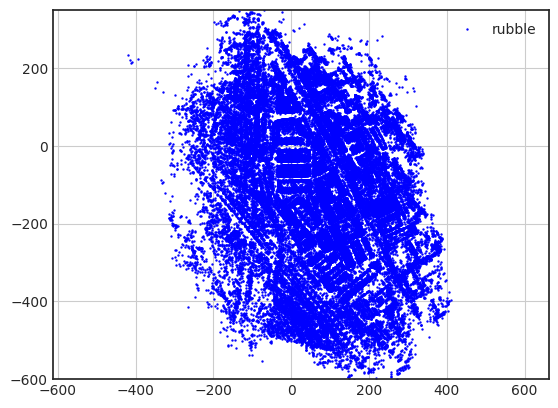

Number of Gaussians: 8374965


In [40]:
plt.figure()
plt.style.use('seaborn-white')
xyz_org = gaussians.get_xyz
plt.scatter(xyz_org[::100, 0].detach().cpu(), xyz_org[::100, 2].detach().cpu(), s=0.5, c='b', label='rubble')
# plt.scatter(cam_centers[:, 0], cam_centers[:, 2], s=10, c='r', label='camera')
# plt.plot([xy_range[0], xy_range[0]], [xy_range[1], xy_range[3]], 'b')
# plt.plot([xy_range[2], xy_range[2]], [xy_range[1], xy_range[3]], 'b')
# plt.plot([xy_range[0], xy_range[2]], [xy_range[1], xy_range[1]], 'b')
# plt.plot([xy_range[0], xy_range[2]], [xy_range[3], xy_range[3]], 'b')
# plt.title(f"xy range: {xy_range}")
plt.axis('equal')
plt.xlim(-350, 400)
plt.ylim(-600, 350)
plt.legend()
plt.grid(True)
plt.show()

print(f"Number of Gaussians: {xyz_org.shape[0]}")

In [70]:
# 17, 0.05 1169
# 17, 0.075 753
# 17, 0.1, 621
# [-275, -100, -300, 200, 900, 450]
# 17, 0.075 957

opacity_list = []
valid_num = 0
with torch.no_grad():
    views = scene.getTrainCameras()  # getTrainCameras, getTestCameras
    for idx in tqdm(range(len(views))):
        bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
        background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
        viewpoint_cam = loadCam(lp, idx, views[idx], 1.0, with_image=False)
        contract_cam_center = contract_to_unisphere(viewpoint_cam.camera_center, aabb, ord=torch.inf)
        if contract_cam_center[0] > org_min_x and contract_cam_center[0] < org_max_x \
            and contract_cam_center[1] > org_min_y and contract_cam_center[1] < org_max_y \
            and contract_cam_center[2] > org_min_z and contract_cam_center[2] < org_max_z:
            valid_num += 1
            # ID = views[idx].image_path.split('/')[-1].split('.')[0]
            # plt.figure()
            # plt.imshow(image_block)
            # plt.title(f'ID: {ID}')
            # plt.show()
            continue
        
        render_pkg_block = render(viewpoint_cam, gaussians, pp, background)
        org_image_block = render_pkg_block["render"]
        visibility_filter = render_pkg_block["visibility_filter"] & (~gs_mask)

        render_pkg_block = render(viewpoint_cam, masked_gaussians, pp, background)
        image_block = render_pkg_block["render"]
        ssim_loss = 1.0 - ssim(image_block, org_image_block)
        image_gt = viewpoint_cam.original_image.cpu().numpy().transpose(1,2,0)

        if ssim_loss > 0.05:
            valid_num += 1
            ID = views[idx].image_path.split('/')[-1].split('.')[0]
            plt.figure(figsize=(16, 8))
            plt.style.use('seaborn-white')
            plt.subplot(1,2,1)
            plt.imshow(np.clip(org_image_block.cpu().numpy().transpose(1,2,0), 0, 1))
            plt.title(f'ID: {ID}, full, loss: {ssim_loss:.4f}')
            plt.axis('off')
            plt.subplot(1,2,2)
            plt.imshow(np.clip(image_block.cpu().numpy().transpose(1,2,0), 0, 1))
            plt.title(f'ID: {ID}, out-of-cell')
            plt.axis('off')
            plt.tight_layout()
            if not os.path.exists(f'../output/vis/{config_name}_{cell_id}'):
                makedirs(f'../output/vis/{config_name}_{cell_id}')
            plt.savefig(f'../output/vis/{config_name}_{cell_id}/{ID}.png')
            plt.close()
            if valid_num > 50:
                break
print(f'Valid_num: {valid_num}')

  2%|▏         | 52/2561 [00:56<45:46,  1.09s/it]

Valid_num: 51
